In [1]:
import pandas as pd
import pdb
from pathlib import Path
from fastai.vision import *
from fastai.vision.gan import *

In [2]:
simDataX = np.linspace(0,2*np.pi,100)
amp,phase = np.random.rand(10000,1), np.random.rand(10000,1) * np.pi
simDataY = amp * np.sin(phase * simDataX.reshape(1,-1))

In [3]:
yT = torch.tensor(simDataY,dtype=torch.float).unsqueeze(-1)
phaseT = torch.tensor(phase,dtype=torch.float).squeeze(1)

trainDS = torch.utils.data.TensorDataset(yT[:8000],yT[:8000].squeeze(-1))
valDS = torch.utils.data.TensorDataset(yT[8000:],yT[8000:].squeeze(-1))
trainDS.items = [1,2,3]
valDS.items = [1,2,3]
data = DataBunch.create(trainDS,valDS,num_workers=0)

In [4]:
class SineEnc(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(100,50)
        self.mean = torch.nn.Linear(50,10)
        self.var = torch.nn.Linear(50,10)
        
    def forward(self,ts):
        h = torch.relu(self.hidden(ts.squeeze(-1)))
        return self.mean(h), self.var(h)

In [5]:
class SineDec(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(10,50)
        self.out = torch.nn.Linear(50,100)
        
    def forward(self,mean,var):
        sample = mean
        if self.training:
            std = torch.exp(0.5 * var)
            eps = torch.randn_like(std)
            sample = eps.mul(std).add_(mean)
        
        h = torch.relu(self.hidden(sample))
        return torch.tanh(self.out(h))

In [6]:
class VAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = SineEnc()
        self.dec = SineDec()
        
    def forward(self,ts):
        mean, var = self.enc(ts)
        out = self.dec(mean,var)
        return out,mean,var

In [7]:
def VAELoss(p,target):
    pred,mean,var = p
    mse = torch.nn.functional.mse_loss(pred,target,reduction="sum")
    kld = -0.5 * torch.sum(1+var-mean.pow(2)-var.exp())
    return mse + 3*kld

In [8]:
model = VAE()
learn = Learner(data,model,loss_func=VAELoss)

In [9]:
x,y = next(iter(data.train_dl))
learn.model(x)[0].shape

torch.Size([64, 100])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


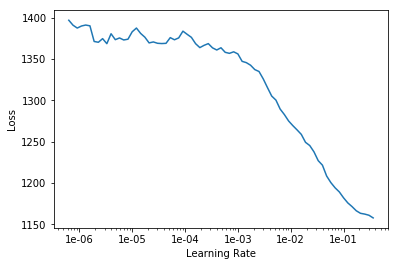

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit(10,1e-3)

epoch,train_loss,valid_loss
1,942.785278,858.510986
2,854.671326,657.770996
3,766.898315,511.512054
4,739.354431,487.158173
5,713.124084,477.288361
6,707.324097,467.320679
7,689.753174,474.008575
8,693.670898,459.717957
9,680.531860,462.802277
10,681.934814,466.156494


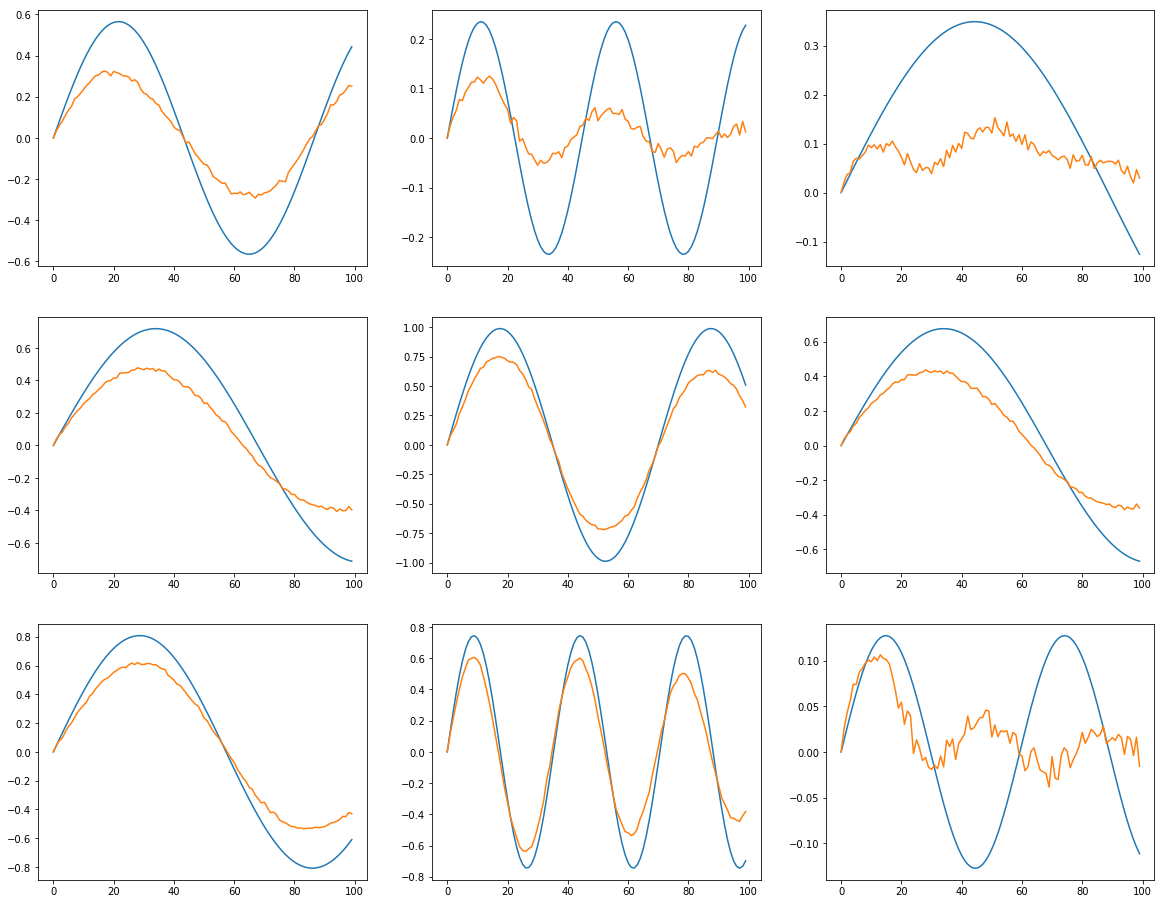

In [12]:
learn.model.eval()
out,_,_ = learn.model(x)
_,axes = plt.subplots(3,3,figsize=(20,16))

for o,r,ax in zip(x,out,axes.flatten()):
    ax.plot(o.flatten())
    ax.plot(r)